# DECam ToO Ledger Maker

Scrape the DECam Texas A&M target identification page for ToOs.

In [1]:
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import json

In [2]:
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.time import Time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rc('font', size=16)

## Access Transient Data

Grab data from the tamu.edu webpage. Note that for some reason the website's SSL certificate is giving the `requests` library issues, even though Chrome has no problem with it.

In [8]:
def access_decam_data(url, overwrite=False):
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    overwrite : bool
        Download new data and overwrite the cached data.
        
    Returns
    -------
    decam_transients : pandas.DataFrame
        Table of transient data.
    """
    folders = url.split('/')
    thedate = folders[-1] if len(folders[-1]) > 0 else folders[-2]
    outfile = '{}.csv'.format(thedate)
    
    if os.path.exists(outfile) and not overwrite:
        # Access cached data.
        decam_transients = pd.read_csv(outfile)
    else:
        # Download the DECam data index.
        # A try/except is needed because the datahub SSL certificate isn't playing well with URL requests.
        try:
            decam_dets = requests.get(url,auth=('decam', 'tamudecam')).text
        except:
            requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
            decam_dets = requests.get(url,auth=('decam', 'tamudecam'), verify=False).text
            
        # Convert transient index page into scrapable data using BeautifulSoup.
        soup = BeautifulSoup(decam_dets)
        
        # Loop through transient object summary JSON files indexed in the main transient page.
        # Download the JSONs and dump the info into a Pandas table.
        decam_transients = None
        j = 0

        for a in soup.find_all('a', href=True):
            if 'object-summary.json' in a:
                link = a['href'].replace('./', '')
                summary_url  = url + link        
                summary_text = requests.get(summary_url,auth=('decam', 'tamudecam'), verify=False).text
                summary_data = json.loads(summary_text)

                j += 1
                #print('Accessing {:3d}  {}'.format(j, summary_url))

                if decam_transients is None:
                    decam_transients = pd.DataFrame(summary_data, index=[0])
                else:
                    decam_transients = pd.concat([decam_transients, pd.DataFrame(summary_data, index=[0])])
                    
        # Cache the data for future access.
        print('Saving output to {}'.format(outfile))
        decam_transients.to_csv(outfile, index=False)
        
    return decam_transients

In [9]:
decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/',overwrite=True)

Saving output to LCData_Legacy.csv


## Access the Transients Table

Dump the info from the transients table here.

If there are particular objects of interest, put them into a ToO ledger for fiberassign.

In [10]:
decam_transients

,ObjectID,RA-OBJECT,DEC-OBJECT,NumberAlerts,MaxSCORE,RA-PSEUDO-HOST,DEC-PSEUDO-HOST,SEP-PSEUDO-HOST,RA-NEIGHBOR-STAR,DEC-NEIGHBOR-STAR,...,Discovery-Round,Discovery-Time,Discovery-Filter,Discovery-Magnitude,Discovery-SNR,Latest-Round,Latest-Time,Latest-Filter,Latest-Magnitude,Latest-SNR
0,A202103221407558m001825,211.982786,-0.306951,12,0.972,211.982614,-0.306946,0.6199,211.983372,-0.306315,...,0,2021-03-22T06:40:19.074,N,22.13,19.2,9,2021-04-18T05:37:55.763,N,22.86,10.2
0,A202103221408139m033502,212.057952,-3.583947,26,0.953,212.057864,-3.583960,0.3199,212.058798,-3.586276,...,0,2021-03-22T08:20:58.209,N,21.78,25.7,18,2021-05-18T06:16:52.581,N,22.10,13.9
0,A202103221408412p002445,212.171737,0.412527,47,0.998,212.171673,0.412394,0.5317,212.174697,0.411566,...,0,2021-03-22T06:36:50.928,S,20.61,36.2,19,2021-05-22T03:10:29.715,S,21.53,16.5
0,A202103221408578m005300,212.241200,-0.883300,2,0.855,212.241200,-0.883400,0.3000,212.239800,-0.884900,...,0,2021-03-22T08:17:30.880,S,22.55,15.5,1,2021-03-24T07:10:51.368,S,22.33,25.6
0,A202103221409059m023156,212.274757,-2.532478,21,0.969,212.274533,-2.532531,0.8290,212.275356,-2.535003,...,0,2021-03-22T08:14:02.747,N,22.27,10.6,18,2021-05-18T03:17:17.544,N,22.99,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,T202105301405547p043407,211.477939,4.568626,2,0.881,211.473443,4.568954,16.1787,211.477656,4.568650,...,22,2021-05-30T02:59:57.315,N,20.73,10.4,22,2021-05-30T04:39:26.875,N,22.46,12.7
0,T202105301432117p040917,218.048953,4.154764,2,0.480,218.032649,4.182142,114.6331,218.047316,4.153485,...,22,2021-05-30T05:38:41.744,S,21.74,10.8,22,2021-05-30T06:16:17.835,S,21.69,10.3
0,T202105301434113p034128,218.547346,3.691341,2,0.702,218.549157,3.689940,8.2327,218.547538,3.691805,...,22,2021-05-30T05:38:41.744,S,21.04,23.9,22,2021-05-30T06:16:17.835,S,21.19,18.7
0,T202105301452527p011841,223.219769,1.311619,3,0.997,223.218727,1.310085,6.6763,223.219019,1.313305,...,22,2021-05-30T05:17:31.450,N,20.18,38.6,22,2021-05-30T06:32:46.888,N,20.25,32.6


In [8]:
decam_transients.columns

Index(['ObjectID', 'RA-OBJECT', 'DEC-OBJECT', 'NumberAlerts', 'MaxSCORE',
       'RA-PSEUDO-HOST', 'DEC-PSEUDO-HOST', 'SEP-PSEUDO-HOST',
       'RA-NEIGHBOR-STAR', 'DEC-NEIGHBOR-STAR', 'SEP-NEIGHBOR-STAR',
       'Discovery-Round', 'Discovery-Time', 'Discovery-Filter',
       'Discovery-Magnitude', 'Discovery-SNR', 'Latest-Round', 'Latest-Time',
       'Latest-Filter', 'Latest-Magnitude', 'Latest-SNR'],
      dtype='object')

### Check Against TNS Transients

Access the DESIRT data stream on TNS. Then compare coordinates from the DECam-DESI target list from Texas A&M to the TNS list.

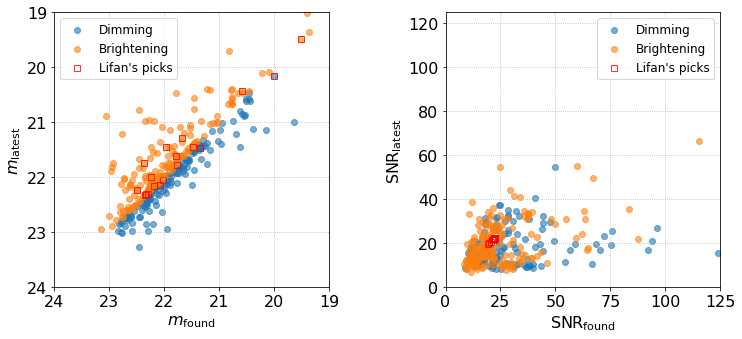

In [9]:
mag_found  = decam_transients['Discovery-Magnitude']
mag_latest = decam_transients['Latest-Magnitude']
snr_found  = decam_transients['Discovery-SNR']
snr_latest = decam_transients['Latest-SNR']

dimmer = mag_latest > mag_found
brighter = np.logical_not(dimmer)

fig, axes = plt.subplots(1,2, figsize=(11,5))

ax = axes[0]
ax.scatter(mag_found[dimmer], mag_latest[dimmer], alpha=0.6, label='Dimming')
ax.scatter(mag_found[brighter], mag_latest[brighter], alpha=0.6, label='Brightening')
ax.scatter(mag_found[select], mag_latest[select], marker='s', edgecolors='r', facecolors='None', alpha=0.8, label="Lifan's picks")
ax.set(aspect='equal',
       xlim=(24,19),#ax.get_xlim()[::-1],
       xlabel=r'$m_{\mathrm{found}}$',
       ylim=(24,19),#ax.get_ylim()[::-1],
       ylabel=r'$m_{\mathrm{latest}}$')
lgd = ax.legend(fontsize=12)
ax.grid(ls=':')

ax = axes[1]
ax.scatter(snr_found[dimmer], snr_latest[dimmer], alpha=0.6, label='Dimming')
ax.scatter(snr_found[brighter], snr_latest[brighter], alpha=0.6, label='Brightening')
ax.scatter(mag_found[select], mag_latest[select], marker='s', edgecolors='r', facecolors='None', alpha=0.8, label="Lifan's picks")
ax.set(aspect='equal',
       xlim=(0,125),
       xlabel=r'$\mathrm{SNR}_{\mathrm{found}}$',
       ylim=(0,125),
       ylabel=r'$\mathrm{SNR}_{\mathrm{latest}}$')
lgd = ax.legend(fontsize=12)
ax.grid(ls=':')
fig.tight_layout();

## Write ToO Ledger

Using the format documented in `/global/cscratch1/sd/adamyers/ToO/dr9/0.50.0.dev4501/ToO/ToO-input.ecsv`, create a list of targets to append to the main ToO ledger.

These will all be in FIBER mode.

In [20]:
def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False,tabformat='TAMU'):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = ['DESIRT','DDF','ALERCE']
        
        if tabformat=='TAMU':
            for i in range(too_table.shape[0]):

                row=too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA-OBJECT'], dec=row['DEC-OBJECT'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['Discovery-Time'], scale='utc')

                mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'DESIRT'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
                
        if tabformat=='ddf':
            for i in range(too_table.shape[0]):

                row=too_table[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = today.mjd #Do not have discovery time so using today

                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc) 
                reporter = 'DDF'
                reporting_id=2
                mjd_exp = 100*mjd_disc + reporting_id
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc, t_disc+14, too_id))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())

### Write Selected Targets

Only select transients that start with T.
If needed, blow away the file first by specifying the argument `overwrite=True`.

In [22]:
#Selecting objects that start with T - more than 0.3 arcsec from galaxy center
#Select objects that were last detected in the past week
select1= decam_transients['ObjectID'].map(lambda x: x.startswith('T'))
today = Time.now()
select2 = decam_transients['Latest-Time'].map(lambda x: Time(x, scale='utc').mjd>today.mjd-10)
select=np.logical_and(select1,select2)
write_too_ledger('ToO-input.ecsv', decam_transients[select], checker='SB/AP', overwrite=True, verbose=True)

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
212.481013   1.692011 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 59295.27075525 59383.58783155 592950001
216.830959   2.072930 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 59310.2

In [17]:
#For now we have just added transients to a new file. If we want to append them to the real ToO file
# we need to double check we are not duplicating ToOs

Now add transients from DDF

In [98]:
ddf_file='DDF_ToOs_April29.tab'
ddf=np.genfromtxt(ddf_file,names=True)
write_too_ledger('ToO-input.ecsv', ddf, checker='SB/AP', verbose=True,tabformat='ddf')

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
211.164300   1.774100 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 59295.27075525 59347.82937587 592950001
211.181700   1.646000 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 59295.2